# Parametric and Non-Parametric Classification


In [0]:
import numpy as np
import matplotlib.pyplot as plt

points2d.dat dataset is used. The sample includes 6000 instances. Each instance is represented by a feature vector of 2 dimensions. The third column corresponds to the class (0/1/2) of the instance.

## A: Mixture of Gaussians. 

Steps:
* Implement mixture of gaussians.
* Divide data to training and validation and test sets.
* At training:
    - Divide all data to their respective classes.
    - Run mixture of gaussians with k=1,2,3 using different initial points (the general practice is to use k-means to initialize the means, you can use sklearn implementation of k-means). 
* At validation, select best model:
    - Using validation data, select best number of gaussians for each class using prediction error.
* On test set, report (for the best model):
    - the number of Gaussians for class 0, 1 and 2,
    - the prediction error, and
    - the confusion matrix.

In [0]:
file = open('points2d.dat', 'r')
data = np.array([])
labels = list()
for line in file:
  words = line.split()
  data = np.concatenate((data, list(map(float, words[:2]))), axis = 0)
  labels.append(int(words[2]))
data = np.reshape(data, (len(data)/2, 2))
x_train = data[:int(len(data)*0.5)]
labels_train = labels[:int(len(labels)*0.5)]
x_valid = data[int(len(data)*0.5):int(len(data)*0.75)]
labels_valid = labels[int(len(labels)*0.5):int(len(labels)*0.75)]
x_test = data[int(len(data)*0.75):]
labels_test = labels[int(len(labels)*0.75):]

In [0]:
def NormalPDF(x, mean, cov, d):
  import math
  return 1/pow((2 * math.pi), -d/2) * pow(abs(np.linalg.det(cov)), -1/2) * np.exp(-1/2 * np.dot(np.dot((x - mean).T, np.linalg.inv(cov)), (x - mean)))

In [0]:
 def EM(xx, k):
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(xx)
    means = kmeans.cluster_centers_
    labeled_data = []
    mixing_coeffs = []
    covs = []
    for i in range(k):
        labeled_data.append([xx[j] for j in range(len(xx)) if labels[j] == i])
        mixing_coeffs.append(len(labeled_data[i]))
        covs.append(np.cov(np.asarray(labeled_data[i]).T))
    mixing_coeffs = np.asarray(mixing_coeffs) / float(len(xx))
    old_loglikelihood = 0
    count = 0
    while True:
        # expectation
        r_ics = np.array([])
        for x in xx:
            list1 = []
            sum_r = 0
            for i in range(k):
                r = float(mixing_coeffs[i]) * NormalPDF(x, means[i], covs[i], 2)
                list1.append(r)
                sum_r += r
            list1 = np.asarray(list1)
            r_ics = np.concatenate((r_ics, list1 / float(sum_r)))
        r_ics = np.reshape(r_ics, (int(len(r_ics) / k), k))

        # maximization
        mcs = np.sum(r_ics, axis=0)
        mixing_coeffs = mcs / float(np.sum(mcs))

        means = np.array([])
        for c in range(k):
            arr = np.sum(r_ics.T[c].reshape(len(xx), 1) * xx, axis=0) / float(np.sum(r_ics.T[c].reshape(len(xx), 1)))
            arr = np.asarray(arr)
            means = np.concatenate((means, arr), axis=0)
        means = means.reshape(k, 2)

        covs = []
        for c in range(k):
            dot_sum = np.array([[0, 0], [0, 0]])
            for i in range(len(xx)):
                dot = np.dot(np.asarray(xx[i] - means[c]).reshape(1, 2).T, np.asarray(xx[i] - means[c]).reshape(1, 2))
                dot = r_ics[i][c] * dot
                dot_sum = dot_sum + (dot / float(mcs[c]))
            covs.append(dot_sum)

        # likelihood
        log_likelihood = 0
        for x in xx:
            temp = 0
            for c in range(k):
                r = mixing_coeffs[c] * NormalPDF(x, means[c], covs[c], 2)
                temp += r
            log_likelihood += np.log(temp)

        if count != 0 and log_likelihood - old_loglikelihood < 0.01:
            return mixing_coeffs, means, covs

        old_loglikelihood = log_likelihood
        count += 1
       

In [5]:
# Train
x_train_0 = np.asarray([x_train[i] for i in range(len(x_train)) if labels_train[i] == 0])
x_train_1 = np.asarray([x_train[i] for i in range(len(x_train)) if labels_train[i] == 1])
x_train_2 = np.asarray([x_train[i] for i in range(len(x_train)) if labels_train[i] == 2])

class_0_models = [EM(x_train_0, 1), EM(x_train_0, 2), EM(x_train_0, 3)]
class_1_models = [EM(x_train_1, 1), EM(x_train_1, 2), EM(x_train_1, 3)]
class_2_models = [EM(x_train_2, 1), EM(x_train_2, 2), EM(x_train_2, 3)]

print class_2_models[1]

(array([0.57541102, 0.42458898]), array([[-1.92445195, -2.92808644],
       [-5.96266218, -4.93996574]]), [array([[ 3.43609232, -1.50410238],
       [-1.50410238,  4.25488207]]), array([[ 2.48472833, -0.90126106],
       [-0.90126106,  5.19681356]])])


In [0]:
# Validation
errors = []

for i_0 in range(3):
    for i_1 in range(3):
        for i_2 in range(3):
            cluster_labels = [0 for n in range(i_0+1)]
            cluster_labels.extend([1 for n in range(i_1+1)])
            cluster_labels.extend([2 for n in range(i_2+1)])
            k = i_0 + i_1 + i_2 + 3
            means = np.concatenate((class_0_models[i_0][1], (np.concatenate((class_1_models[i_1][1], class_2_models[i_2][1]), axis=0))), axis=0)
            covs = np.concatenate((class_0_models[i_0][2], (np.concatenate((class_1_models[i_1][2], class_2_models[i_2][2]), axis=0))), axis=0)
            mixing_coeffs = np.concatenate((class_0_models[i_0][0], (np.concatenate((class_1_models[i_1][0], class_2_models[i_2][0]), axis=0))), axis=0)
            error = 0
            for v in range(len(x_valid)):
                list1 = []
                for i in range(k):
                    r = float(mixing_coeffs[i]) * NormalPDF(x_valid[v], means[i], covs[i], 2)
                    list1.append(r)
                    
                if labels_valid[v] != cluster_labels[list1.index(max(list1))]:
                    error += 1
            errors.append((error / float(len(x_valid)), i_0, i_1, i_2))
            

In [0]:
err, ind_model_0, ind_model_1, ind_model_2 = min(errors)


In [0]:
# Test
cluster_labels = [0 for n in range(ind_model_0 + 1)]
cluster_labels.extend([1 for n in range(ind_model_1 + 1)])
cluster_labels.extend([2 for n in range(ind_model_2 + 1)])
k = ind_model_0 + ind_model_1 + ind_model_2 + 3
means = np.concatenate(
    (class_0_models[ind_model_0][1], (np.concatenate((class_1_models[ind_model_1][1], class_2_models[ind_model_2][1]), axis=0))), axis=0)
covs = np.concatenate(
    (class_0_models[ind_model_0][2], (np.concatenate((class_1_models[ind_model_1][2], class_2_models[ind_model_2][2]), axis=0))), axis=0)
mixing_coeffs = np.concatenate(
    (class_0_models[ind_model_0][0], (np.concatenate((class_1_models[ind_model_1][0], class_2_models[ind_model_2][0]), axis=0))), axis=0)
error = 0
gmm_labels = []
for t in range(len(x_test)):
    list1 = []
    for i in range(k):
        r = float(mixing_coeffs[i]) * NormalPDF(x_test[t], means[i], covs[i], 2)
        list1.append(r)
    temp_lbl = cluster_labels[list1.index(max(list1))]
    gmm_labels.append(temp_lbl)
    if labels_test[t] != temp_lbl:
        error += 1
        

error = error / float(len(x_test))

Best Model:
	 For Class 0, k = 2
	 For Class 1, k = 2
	 For Class 2, k = 2
Prediction Error: 0.300000


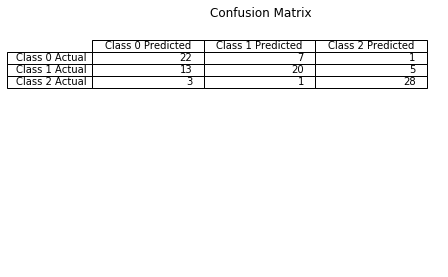

In [9]:
# Report
print('Best Model:')
print('\t For Class 0, k = %d' % (ind_model_0 + 1))
print('\t For Class 1, k = %d' % (ind_model_1 + 1))
print('\t For Class 2, k = %d' % (ind_model_2 + 1))
print('Prediction Error: %f' % error)

conf_matrix = np.array([[0,0,0], [0,0,0], [0,0,0]])
for i in range(len(labels_test)):
  conf_matrix[labels_test[i]][gmm_labels[i]] += 1

col = ['Class 0 Predicted', 'Class 1 Predicted', 'Class 2 Predicted']
row = ['Class 0 Actual', 'Class 1 Actual', 'Class 2 Actual']

fig = plt.figure()
fig.suptitle('Confusion Matrix')

axs = plt.subplot()
plt.table(cellText=conf_matrix,
                      rowLabels=row,
                      colLabels=col,
                      loc='best')
axs.axis('off')
plt.show()

## B: K-Nearest Neighbor
Steps:
* Implement k-nearest neighbor. 
* Run it with k=1,10,40. 
* Using test set, Report
    - best k,
    - prediction error for all k’s.
    - confusion matrix for all k’s.

In [0]:
def KNN(xx_train, train_labels, xx_test, k):
  labels = []
  for x in xx_test:
    l = [(np.linalg.norm(x - xx_train[i]), train_labels[i]) for i in range(len(xx_train))]
    l.sort(key=lambda x: x[0])
    votes = [0, 0, 0]
    for tuple in l[:k]:
      votes[tuple[1]] += 1
    most_voted = votes.index(max(votes))
    labels.append(most_voted)
  return labels

knn_labels = [KNN(x_train, labels_train, x_test, 1)]
knn_labels.append(KNN(x_train, labels_train, x_test, 10))
knn_labels.append(KNN(x_train, labels_train, x_test, 40))



Best k: 10
Prediction Errors:
	k = 1: 0.33
	k = 10: 0.26
	k = 40: 0.27


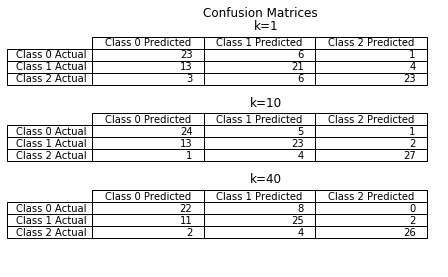

In [11]:
err  = [0, 0, 0]
conf_matrices = []
for l in range(len(knn_labels)):
  conf_matrix = np.array([[0,0,0], [0,0,0], [0,0,0]])
  for i in range(len(labels_test)):
    if knn_labels[l][i] != labels_test[i]:
      err[l] += (1.0 / len(labels_test))
    conf_matrix[labels_test[i]][knn_labels[l][i]] += 1
  conf_matrices.append(conf_matrix)

best_k = 0
ind = err.index(min(err))
if ind == 0:
  best_k = '1'
elif ind == 1:
  best_k = '10'
else:
  best_k = '40'

print('Best k: ' + best_k)
print ('Prediction Errors:')
print('\tk = 1: ' + str(err[0]))
print('\tk = 10: ' + str(err[1]))
print('\tk = 40: ' + str(err[2]))

cols = ['Class 0 Predicted', 'Class 1 Predicted', 'Class 2 Predicted']
rows = ['Class 0 Actual', 'Class 1 Actual', 'Class 2 Actual']

fig = plt.figure()
fig.suptitle('Confusion Matrices')

axs = plt.subplot(3,1,1)
plt.table(cellText=conf_matrices[0],
                      rowLabels=rows,
                      colLabels=cols,
                      loc='best')
plt.title('k=1')
axs.axis('off')

axs2 = plt.subplot(3,1, 2)
plt.table(cellText=conf_matrices[1],
                      rowLabels=rows,
                      colLabels=cols,
                      loc='best')
plt.title('k=10')
axs2.axis('off')

axs3 = plt.subplot(3,1,3)
plt.table(cellText=conf_matrices[2],
                      rowLabels=rows,
                      colLabels=cols,
                      loc='best')
plt.title('k=40')
axs3.axis('off')
plt.show()